# Identify Fraudulent Activities
## Goal: 

Every day E-commerce websites often transact huge amount of money, however, no matter how careful we are, there are always risk that fraud could happen, such as using stolen credit cards, using other's account, etc. The goal of this challenge is to predict the probability that the first transaction of a new user is fraudulent via Machine Learning Models.
## Background Description:
Company XYZ is an e-commerce site that sells hand-made clothes.

Build a model that predicts whether a user has a high probability of using the site to preform some illegal activity or not. The information I have is about the user first transaction on the site and based on that you have to make your classification(fraud/no fraud).

Before dealing with the data, I listed several tasks that might guide me to solve the problem:
* For each user, determine his/her country based on the IP address
* BUild a model to predict whether an activity is fraudulent or not. Give a cost matrix of FP/FN with different values, and choose the best one, explain how it may impact the model.
* Explain to non-tech people how the model works as fraud detection. From a user prespective, what kinds of users are more likely to be classified as a risk? What are their characteristics?
* If the model can be used live to predict in real time whether a activity is fraud or not. Froma a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Dataset description:
There are 2 datasets:

**Fraud_data.csv** about each user first transaction,

**IpAddress_data.csv** mapping each numeric IP address to its country. For each country, there is a range of IP addresses to indicate it. 

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [92]:
fraud_df = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\fraud_data.csv")
ipaddress_df = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\IpAddress_to_Country.csv")

In [93]:
pd.DataFrame(ipaddress_df.head())
pd.DataFrame(ipaddress_df.tail())
#we can see the lower_bound and upper_bound are continuous ascending for each rows, but notice, it's common that
#there are multiple range of IP address of the same country.

,lower_bound_ip_address,upper_bound_ip_address,country
103890,3.349553e+09,3349553663,United States
103891,3.349554e+09,3349554175,India
103892,3.349554e+09,3349554687,India
103893,3.349555e+09,3349554943,Canada
103894,3.349555e+09,3349555199,Can


In [94]:
pd.DataFrame(fraud_df.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0
3,150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0
4,221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0


### Sanity Check

In [95]:
ipaddress_df.country.value_counts().head()
#there are 230 countries

United States         33548
Russian Federation     6308
Germany                5540
United Kingdom         4992
Brazil                 3944
Name: country, dtype: int64

In [8]:
fraud_df.describe()
#the last user_Id is incomplete only with user_id, but no other information, so drop it

,user_id,purchase_value,age,ip_address,class
count,30190.000000,30189.000000,30189.000000,3.018900e+04,30189.000000
mean,200930.974561,36.922356,33.044188,2.147769e+09,0.094968
std,115503.227945,18.394795,8.603925,1.251775e+09,0.293176
min,4.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,101164.500000,22.000000,27.000000,1.071238e+09,0.000000
50%,201469.500000,34.000000,32.000000,2.149716e+09,0.000000
75%,300589.000000,49.000000,39.000000,3.240203e+09,0.000000
max,399995.000000,154.000000,73.000000,4.294822e+09,1.000000


In [19]:
print(fraud_df.isna().sum())
#there is only 1 record with NaNa among 30189 records. Just drop it.
print(fraud_df.loc[30189])

user_id           0
signup_time       0
purchase_time     1
purchase_value    1
device_id         1
source            1
browser           1
sex               1
age               1
ip_address        1
class             1
dtype: int64
user_id                    393385
signup_time       8/11/2015 19:00
purchase_time                 NaN
purchase_value                NaN
device_id                     NaN
source                        NaN
browser                       NaN
sex                           NaN
age                           NaN
ip_address                    NaN
class                         NaN
Name: 30189, dtype: object


In [96]:
fraud_df = fraud_df[:-1]

In [97]:
#set user_id as index in fraud_df
fraud_df.set_index('user_id').head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
user_id,,,,,,,,,,
22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0
333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0
1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0
150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0
221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0


### 1. For each user, determine his/her country based on the IP address
In Ip_Address_to_country dataset, we have lowbound and upperbound of IP address, mapping each country. With each IP address in fraud_df, mapping it to the IP range in Ip_Address_to_country dataset. The way I used is to
try **Binary Search** to map IP address to country

In [98]:
import bisect
class IPlookupTable(object):
    def __init__(self, df):
        #input IpAddress_data.csv
        self._nrows = df.shape[0]
        #print(self._nrows)
        #In each row, set IpAddress as 0
        #and the country as 'Unknown'
        self._ip_lowbounds = [0 for _ in range(self._nrows + 2)]
        self._countries = ['Unknown' for _ in range(self._nrows + 2)]
        #starting from 1th row
        for r in range(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r-1,0]
            self._countries[r] = df.iloc[r-1,2]
            if self._ip_lowbounds[r] > self._ip_lowbounds[r-1]:
            #since each country has multiple range of Ip address, 
            #we cannot assign all ip >last lower bound is that country
            #so create a dummy ipaddress which larger tahn max known ip
                self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows -1, 1]
        
    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
            #within the range, or in last cell which has no next cell
        if ip >= self._ip_lowbounds[index] and (index == self._nrows + 1
                                                       or ip < self._ip_lowbounds[index + 1]):
            #the given ip is inside the range(index), get the index
            return self._countries[index]

In [15]:
ipaddress_df.shape[0]

103895

In [99]:
iplookuptable = IPlookupTable(ipaddress_df)

In [100]:
fraud_df['country'] = fraud_df.ip_address.map(iplookuptable.find_country)

In [18]:
fraud_df.sample(8)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
2063,70260,2/20/2015 7:40,5/3/2015 15:27,22.0,AOHXHNUTEHGOG,Ads,Chrome,M,31.0,8.457130e+08,0.0,United States
8547,36891,2/27/2015 21:21,3/9/2015 3:18,21.0,JDZSFKFZJCUYT,SEO,IE,M,36.0,6.508185e+08,0.0,United States
11192,259013,2/8/2015 22:06,3/6/2015 23:08,32.0,FJHLIPLLEELQP,Direct,FireFox,M,33.0,1.350897e+09,0.0,Germany
1841,326466,4/20/2015 7:46,6/11/2015 21:34,38.0,VZFNJUCACYHCD,SEO,Chrome,M,22.0,2.462580e+09,0.0,United States
2698,305311,8/5/2015 14:59,9/20/2015 10:27,43.0,BEXBHTANQYPRB,SEO,IE,M,41.0,4.282655e+09,0.0,Unknown
16658,209140,6/4/2015 1:28,9/12/2015 9:22,38.0,ZEHCUUWNHBTYT,SEO,IE,M,28.0,7.157568e+08,0.0,China
12681,240027,2/27/2015 10:12,6/16/2015 4:47,39.0,UTGVGUIFEZNIX,Ads,FireFox,F,21.0,3.146974e+09,0.0,Mexico
17428,339021,8/9/2015 18:54,8/23/2015 3:38,54.0,WVKEGVNRJHCFD,SEO,FireFox,M,31.0,1.250931e+09,0.0,United States


In [72]:
fraud_df.country.value_counts()

United States                      10815
Unknown                             6993
China                               2053
Japan                               1227
United Kingdom                       848
Germany                              650
Korea Republic of                    604
France                               586
Canada                               518
Brazil                               459
Italy                                339
Netherlands                          325
Australia                            301
Russian Federation                   294
India                                228
Taiwan; Republic of China (ROC)      199
Sweden                               190
Spain                                186
Mexico                               165
South Africa                         163
Switzerland                          134
Poland                               133
Indonesia                            128
Argentina                            123
Norway          

Here we can see the largest amount of users come from United States, while many users come from countries outside the Ip_Country_df, which needs more investigate and there are several user come from very rare countries

In [20]:
#check all IP from 'Unknown' country are either < minip or >maxip
minip = ipaddress_df.iloc[0,0]
maxip = ipaddress_df.iloc[-1,1]
country_unknown = fraud_df.loc[fraud_df.country == 'Unknown', 'ip_address']
smaller_than_min = country_unknown < minip
larger_than_max = country_unknown > maxip
print(len(smaller_than_min), len(larger_than_max))

6993 6993


In [21]:
#min max of ipaddress_df
minip = ipaddress_df.iloc[0,0]
maxip = ipaddress_df.iloc[-1,1]
print('min, max of ipaddress_df:', minip, maxip)
minip_f = fraud_df.ip_address.min()
maxip_f = fraud_df.ip_address.max()
print('min, max of fraud_df:', minip_f, maxip_f)

min, max of ipaddress_df: 16777216.0 3349555199
min, max of fraud_df: 93447.13896 4294822242.0


Here we can see the min IP of fraud_df is 93447, while min IP of Ipaddress_df is 16777216, max IP of fraud_df is 4294822242, while max IP of Ipaddress_df is 3349555199, that explain why there are so many user with country 'Unknown'. If we want to get more information, we'd better update the IPaddress_df to include more IP address to locate the customers.

### 2. Check all other features & feature engineering
Before building up the predictive model, we need to do some clean_up and feature engineering.
#### 1. convert signup_time/purchase_time

In [22]:
fraud_df.set_index('user_id').sample(6)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
user_id,,,,,,,,,,,
149432,5/6/2015 3:53,5/9/2015 2:42,50.0,NZCZQFMPLGYRD,SEO,Chrome,M,33.0,8.227326e+08,0.0,Korea Republic of
320652,1/19/2015 22:05,4/17/2015 13:42,9.0,CXXDDKYUNYLNB,SEO,IE,M,45.0,1.607112e+09,0.0,Sweden
13574,3/23/2015 0:39,5/23/2015 12:51,78.0,QNBFPOYHYKNLD,SEO,IE,M,28.0,3.567517e+09,0.0,Unknown
292018,1/14/2015 3:42,4/22/2015 2:08,27.0,OCQAUVYLMURES,SEO,Chrome,M,44.0,5.114404e+08,0.0,United States
51068,8/11/2015 3:30,9/2/2015 13:22,27.0,TFEYTVOGEXOMV,Ads,FireFox,M,48.0,4.042265e+09,0.0,Unknown
299332,7/8/2015 3:30,10/2/2015 7:12,11.0,PSTUPCDPKWTPR,Direct,Chrome,F,28.0,1.042680e+09,0.0,Greece


In [101]:
fraud_df['signup_date'] = pd.to_datetime(fraud_df.signup_time)
fraud_df['purchase_date'] = pd.to_datetime(fraud_df.purchase_time)

In [102]:
import datetime as dt
fraud_df['signup_date'] = fraud_df.signup_date.dt.date
fraud_df['purchase_date'] = fraud_df.purchase_date.dt.date

In [25]:
fraud_df.sample(6)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_date,purchase_date
30048,231553,1/24/2015 8:35,4/28/2015 10:39,49.0,OCTAIEXQAVKCV,Ads,IE,F,27.0,4.258912e+09,0.0,Unknown,2015-01-24,2015-04-28
22581,250987,7/20/2015 6:26,8/14/2015 0:29,13.0,CAGGNUWWZHENV,Ads,Chrome,M,20.0,2.879067e+09,0.0,United States,2015-07-20,2015-08-14
19415,183988,7/21/2015 20:06,9/5/2015 23:53,29.0,QXDZBUKYPRNST,Ads,Safari,F,43.0,3.193632e+09,0.0,Colombia,2015-07-21,2015-09-05
26649,44245,1/25/2015 13:50,4/3/2015 1:11,41.0,FJSGBXLIFLLMM,SEO,IE,F,38.0,4.031892e+09,0.0,Unknown,2015-01-25,2015-04-03
2004,392857,2/15/2015 23:21,5/18/2015 14:18,26.0,NMGQVPSADNRWX,Ads,Safari,M,26.0,4.273260e+09,0.0,Unknown,2015-02-15,2015-05-18
10244,396992,5/17/2015 10:35,7/5/2015 14:38,17.0,JJSRWBVSERUMK,Ads,Chrome,F,29.0,8.287784e+08,0.0,Japan,2015-05-17,2015-07-05


In [33]:
#check the min/max range of date
print('Last Signup date', fraud_df.signup_date.max())
print('First Signup date', fraud_df.signup_date.min())
print('Last Purchase date', fraud_df.purchase_date.max())
print('First Purchase date', fraud_df.purchase_date.min())

Last Signup date 2015-08-18
First Signup date 2015-01-01
Last Purchase date 2015-12-14
First Purchase date 2015-01-01


In [103]:
#check the interval of signup and purchase, if the interval is extremely small/large, that's suspicious
fraud_df['interval_sp'] = (fraud_df.purchase_date - fraud_df.signup_date).dt.days

In [35]:
#plot_bar function
def get_line_plot_simply(xlabel, df):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    title = "Distribution of " + xlabel
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Count', fontsize = 15)
    vc = df[xlabel].value_counts(dropna = False)
    vcsum = vc.sum()
    vc.plot(kind = 'line', ax = ax)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize = 15)

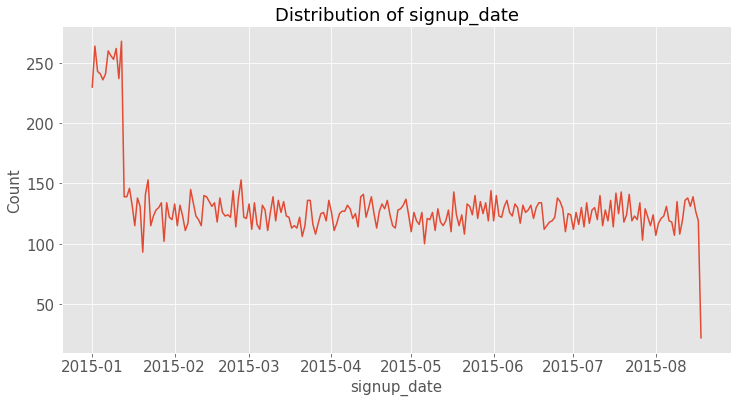

In [36]:
#plot simply
get_line_plot_simply('signup_date', fraud_df)

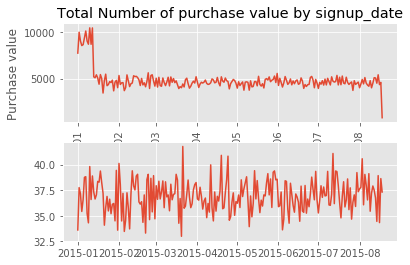

In [46]:
plt.subplot(211)
plt.title("Total Number of purchase value by signup_date")
plt.xlabel("Date")
plt.xticks(rotation= 'vertical')
plt.ylabel("Purchase value")
g1 = fraud_df.groupby('signup_date')['purchase_value'].agg('sum')
g2 = fraud_df.groupby('signup_date')['purchase_value'].agg('mean')
plt.plot(g1)
plt.subplot(212)
plt.plot(g2)

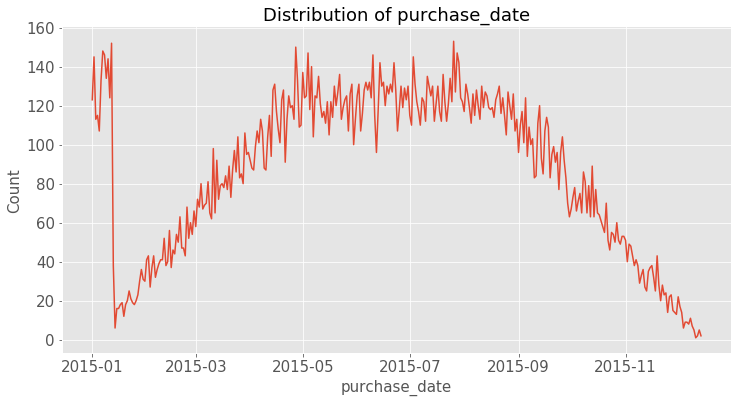

In [37]:
get_line_plot_simply('purchase_date', fraud_df)

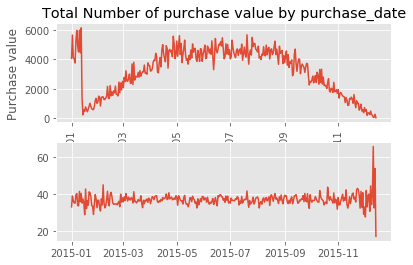

In [47]:
plt.subplot(211)
plt.title("Total Number of purchase value by purchase_date")
plt.xlabel("Date")
plt.xticks(rotation= 'vertical')
plt.ylabel("Purchase value")
g1 = fraud_df.groupby('purchase_date')['purchase_value'].agg('sum')
g2 = fraud_df.groupby('purchase_date')['purchase_value'].agg('mean')
plt.plot(g1)
plt.subplot(212)
plt.plot(g2)

As the up two plots show, we notice there is a huge drop during the middle of Janurary for both signup and purchase. For signup, after that drop from 250, the count stays stable at 100~150, which may due to a huge change of their website/products/price or competitions from other companies. For purchase, after drop, the distribution increase to the original point and then decrease to 0. Since the signup date is till 2015-08, it's possible that the website acquire no more user so the purchase starting decrease since 2015-08. Need to find out the reason if we want to attract more customers. 

Relationship of average Purchase value and signup_date/ purchase_date show no obvious changes. Of total value follows the distribution of count.

But since we are focusing on fraudulent activity detection, analyzing about the purchase value should be considered in other projects

#### 2. categorical features
sex, source, browser, first plot and then one-hot-encoding

In [104]:
#plot_bar function
def get_bar_plot(xlabel, df):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121)
    title = "Distribution of " + xlabel
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Count', fontsize = 15)
    vc = df[xlabel].value_counts(dropna = False)
    vcsum = vc.sum()
    vc.plot(kind = 'bar', ax = ax)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize = 15)
    for i,v in vc.reset_index().iterrows():
        ax.text(i,v[xlabel]+1, v[xlabel],ha='left', va='bottom', fontsize = 12)
        ax.text(i,(v[xlabel]/vcsum).round(3) + 1, (v[xlabel]/vcsum).round(3),ha='center', va='top', fontsize = 14)

In [105]:
def get_class_plot(df, v1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dc = df.groupby([v1, 'class'])['user_id'].count().unstack()
    print(dc)
    dcsum = dc.sum()
    dc.plot(kind = 'bar', ax= ax)
    plt.title('Distribution of fraud/non-fraud for ' + v1 + ' type' , fontsize = 14)
    plt.xlabel(v1, fontsize = 14)
    plt.ylabel("Count", fontsize = 14)
    plt.xticks( fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(loc='upper right', fontsize = 14)

class    0.0   1.0
sex               
F      11381  1148
M      15941  1719


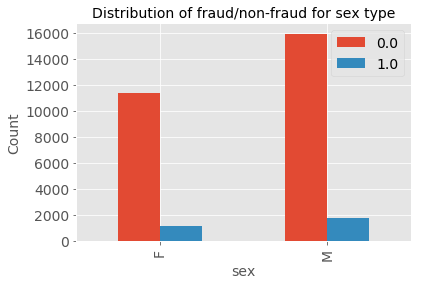

In [106]:
#sex
get_class_plot(fraud_df, 'sex')

class     0.0   1.0
source             
Ads     10847  1084
Direct   5418   675
SEO     11057  1108


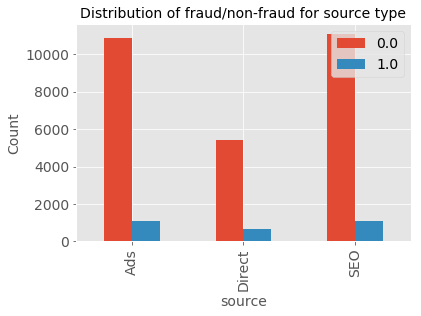

In [108]:
#get_bar_plot('source', fraud_df)
get_class_plot(fraud_df, 'source')

class      0.0   1.0
browser             
Chrome   11001  1252
FireFox   4417   474
IE        6749   635
Opera      641    77
Safari    4514   429


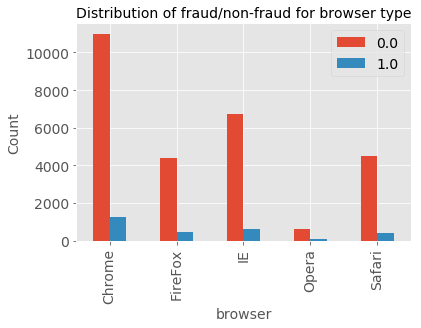

In [110]:
get_class_plot(fraud_df, 'browser')

#### 3. Coding for Shared device & IP address
* Device_id is string, which are not a good feature for predictive model, so information need to be extracted and converted to applicable features. So does IP_address

Check how many users have unique device/IP address? Since this dataset records the first transaction, if the device is shared by multiple users, and the more users it's shared with, the more suspicious it is.

In [111]:
print('Total number of device:', fraud_df.device_id.value_counts().shape[0])
print('Number of shared device:',len(fraud_df.device_id.value_counts()[fraud_df.device_id.value_counts()>1]))
#there are 705/28949 devices are shared.

Total number of device: 28949
Number of shared device: 705


In [112]:
fraud_df['num_device_shared'] = fraud_df.device_id.map(fraud_df.device_id.value_counts())

In [113]:
#check shared IP address
print('total IP address:', len(fraud_df.ip_address.value_counts()))
print('Number of shared IP:', len(fraud_df.ip_address.value_counts()[fraud_df.ip_address.value_counts()>1]))
#there are 503/29156 IPs are shared

total IP address: 29156
Number of shared IP: 503


In [114]:
fraud_df['num_ip_shared'] = fraud_df.ip_address.map(fraud_df.ip_address.value_counts())

In [115]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_date,purchase_date,interval_sp,num_device_shared,num_ip_shared
0,22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0,Japan,2015-02-24,2015-04-18,53,1,1
1,333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0,United States,2015-06-07,2015-06-08,1,1,1
2,1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0,United States,2015-01-01,2015-01-01,0,3,3
3,150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0,Unknown,2015-04-28,2015-05-04,6,1,1
4,221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0,United States,2015-07-21,2015-09-09,50,1,1


In [125]:
#After done feature engineering, some features could be dropped, since their information have been extracted
fraud_df = fraud_df.drop(['signup_time', 'purchase_time', 'device_id', 'ip_address'], axis = 1)
fraud_df.head()

,user_id,purchase_value,sex,age,class,country,signup_date,purchase_date,interval_sp,num_device_shared,num_ip_shared,male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,34.0,M,39.0,0.0,Japan,2015-02-24,2015-04-18,53,1,1,1,0,0,1,1,0,0,0,0
1,333320,16.0,F,53.0,0.0,United States,2015-06-07,2015-06-08,1,1,1,0,1,0,0,1,0,0,0,0
2,1359,15.0,M,53.0,1.0,United States,2015-01-01,2015-01-01,0,3,3,1,0,0,1,0,0,0,1,0
3,150084,44.0,M,41.0,0.0,Unknown,2015-04-28,2015-05-04,6,1,1,1,0,0,1,0,0,0,0,1
4,221365,39.0,M,45.0,0.0,United States,2015-07-21,2015-09-09,50,1,1,1,1,0,0,0,0,0,0,1


In [117]:
sex_dummies = pd.get_dummies(fraud_df.sex)
sex_dummies
fraud_df['male'] = sex_dummies.M

In [118]:
fraud_df = pd.get_dummies(fraud_df, columns = ['source', 'browser'])

In [120]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,country,...,num_ip_shared,male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,M,39.0,7.327584e+08,0.0,Japan,...,1,1,0,0,1,1,0,0,0,0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,F,53.0,3.503114e+08,0.0,United States,...,1,0,1,0,0,1,0,0,0,0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,M,53.0,2.621474e+09,1.0,United States,...,3,1,0,0,1,0,0,0,1,0
3,150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,M,41.0,3.840542e+09,0.0,Unknown,...,1,1,0,0,1,0,0,0,0,1
4,221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,M,45.0,4.155831e+08,0.0,United States,...,1,1,1,0,0,0,0,0,0,1


In [126]:
#since get dummies, the last value can be represented by others, so drop the last column
fraud_df = fraud_df.drop(['sex','source_Direct', 'browser_Opera'],axis = 1)
fraud_df.head()

,user_id,purchase_value,age,class,country,signup_date,purchase_date,interval_sp,num_device_shared,num_ip_shared,male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
0,22058,34.0,39.0,0.0,Japan,2015-02-24,2015-04-18,53,1,1,1,0,1,1,0,0,0
1,333320,16.0,53.0,0.0,United States,2015-06-07,2015-06-08,1,1,1,0,1,0,1,0,0,0
2,1359,15.0,53.0,1.0,United States,2015-01-01,2015-01-01,0,3,3,1,0,1,0,0,0,0
3,150084,44.0,41.0,0.0,Unknown,2015-04-28,2015-05-04,6,1,1,1,0,1,0,0,0,1
4,221365,39.0,45.0,0.0,United States,2015-07-21,2015-09-09,50,1,1,1,1,0,0,0,0,1


In [128]:
#save file
fraud_df.to_csv("fraud_cleaned_df.csv", header = True, index = False)

###  Build a model to predict whether an activity is fraudulent or not. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.
Since this is a binary classification problem, I prefer to use **tree based models**, try decision tree first and then ensemble models such as random forest,adaboost, due to their high flexibility and acceptance capability of various kinds of features, high interpretability and most importantly, they will provide feature importance of the prediction problem, which is quite useful for providing solutions and recommendations.

In [132]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, \
roc_curve, roc_auc_score, precision_score, \
recall_score, f1_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [141]:
fraud_cleaned_df = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\fraud_cleaned_df.csv", index_col = 'user_id')

In [142]:
fraud_cleaned_df.head()

,purchase_value,age,class,country,interval_sp,num_device_shared,num_ip_shared,male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
user_id,,,,,,,,,,,,,,
22058,34,39,0,Japan,53,1,1,1,0,1,1,0,0,0
333320,16,53,0,United States,1,1,1,0,1,0,1,0,0,0
1359,15,53,1,United States,0,3,3,1,0,1,0,0,0,0
150084,44,41,0,Unknown,6,1,1,1,0,1,0,0,0,1
221365,39,45,0,United States,50,1,1,1,1,0,0,0,0,1


In [143]:
fraud_cleaned_df.dtypes

purchase_value        int64
age                   int64
class                 int64
country              object
interval_sp           int64
num_device_shared     int64
num_ip_shared         int64
male                  int64
source_Ads            int64
source_SEO            int64
browser_Chrome        int64
browser_FireFox       int64
browser_IE            int64
browser_Safari        int64
dtype: object

In [145]:
X = fraud_cleaned_df.drop('class', axis= 1)
y = fraud_cleaned_df['class']


In [146]:
#split data into train/test dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.25, random_state = 1)
print(Xtrain.shape)

(22641, 13)


In [147]:
try_forest = RandomForestClassifier(n_estimators = 100,
                           max_depth = 10,
                            min_samples_split = 5, 
                            min_samples_leaf = 5, 
                            oob_score = True,
                            random_state = 2)
#for rf, since it has oob, not need to split dataset into train/test
try_forest.fit(X,y)
y_p = rf.predict_proba(X)[:,1]
print("oob score:", try_forest.oob_score_)
print("auc score:", roc_auc_score(y, y_p))

ValueError: could not convert string to float: 'Unknown'

In [ ]:
#Evaluation
metrics_list = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1_Score']
# 'Confusion_matrix']
def get_performance_metrics(ytrain, ytrain_p, yvalid, yvalid_p):
    metrics_df = pd.DataFrame(columns = ['train', 'valid'])
    metrics_df.loc['Accuracy'] = [accuracy_score(ytrain, ytrain_p), accuracy_score(yvalid, yvalid_p)]
    metrics_df.loc['Precision'] = [precision_score(ytrain, ytrain_p), precision_score(yvalid, yvalid_p)]
    metrics_df.loc['Recall'] = [recall_score(ytrain, ytrain_p), recall_score(yvalid, yvalid_p)]
    metrics_df.loc['f1_score'] = [f1_score(ytrain, ytrain_p), f1_score(yvalid, yvalid_p)]
    metrics_df.loc['AUC'] = [roc_auc_score(ytrain, ytrain_p), roc_auc_score(yvalid, yvalid_p)]
    metrics_df.loc['Matthews_Corrcoef'] = [matthews_corrcoef(ytrain, ytrain_p), matthews_corrcoef(yvalid, yvalid_p)]
    return metrics_df

def get_confusion_matrix(y_valid, y_predict):
    cm = pd.DataFrame(confusion_matrix(y_valid, y_predict), \
                      columns = ['Predicted Active', 'Predicted Churn'], \
                      index = ['True Active', 'True Churn'])
    return cm

def plot_roc_curve(y_train, y_train_prob, y_valid, y_valid_prob, model):
    fpr, tpr, threshold = roc_curve(y_train, y_train_prob)
    fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, y_valid_prob)
    roc_auc_train = auc(fpr, tpr)
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    
    #plot roc curve
    plt.figure()
    plt.title('Receiver Operating Characteristic of ' + model)
    plt.plot(fpr, tpr, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_valid, tpr_valid, 'r', label = 'Valid AUC = %0.2f' % roc_auc_valid)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()